In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
import xarray as xr
import numpy as np
import pandas as pd
import os
import datetime
import shutil
import glob
import calendar
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tempfile
import numpy as np
from scipy import stats
from PIL import Image
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# List of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

wind_data = 'datasets/data_t.nc'
current_data = 'datasets/cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_1740187181287.nc'
ssh_data = 'datasets/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1740483994742.nc'
sst_data = 'datasets/MUR_Monthly_SST_.nc'
sss_data = 'datasets/cmems_obs-mob_glo_phy-sss_my_multi_P1M_1740653508523.nc'

In [3]:
cui_ds = xr.open_dataset('datasets/CUI_2010_2017.nc')

In [23]:
cui_ds



<xarray.Dataset>
Dimensions:     (latitude: 33, longitude: 89, valid_time: 2922, time: 96)
Coordinates:
  * latitude    (latitude) float64 -2.0 -1.75 -1.5 -1.25 ... 5.25 5.5 5.75 6.0
  * longitude   (longitude) float64 -12.0 -11.75 -11.5 -11.25 ... 9.5 9.75 10.0
  * valid_time  (valid_time) datetime64[ns] 2010-01-01 2010-01-02 ... 2017-12-31
    number      int64 0
    depth       float32 15.0
  * time        (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2017-12-31
Data variables:
    τa          (valid_time, latitude, longitude) float32 nan nan ... 0.001258
    ECUI        (valid_time, latitude, longitude) float64 nan nan ... 5.386e-07
    GCUI        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-10T17:47 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
cui_mean = cui_ds.mean(dim=['latitude'])

In [5]:
# Compute GCUI mean over 'time'
gcui_mean = cui_mean['GCUI'].mean(dim='time', skipna=True) *86400

# Compute ECUI mean over 'valid_time'
ecui_mean = cui_mean['ECUI'].mean(dim='valid_time', skipna=True) *86400

# Compute CUI = ECUI + GCUI
cui_total = ecui_mean + gcui_mean


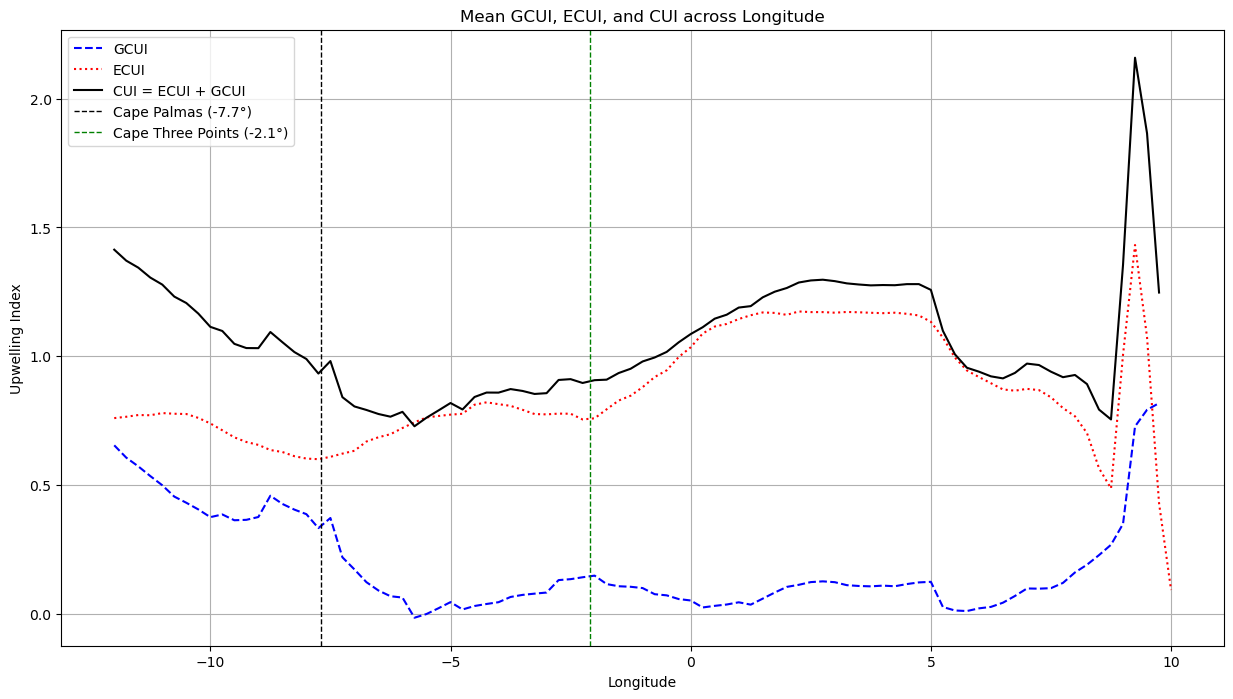

In [6]:
plt.figure(figsize=(15, 8))

# Plot GCUI
plt.plot(cui_mean['longitude'], gcui_mean, label="GCUI", linestyle="--", color="blue")

# Plot ECUI
plt.plot(cui_mean['longitude'], ecui_mean, label="ECUI", linestyle=":", color="red")

# Plot CUI
plt.plot(cui_mean['longitude'], cui_total, label="CUI = ECUI + GCUI", linestyle="-", color="black")
cape_palmas_lon = -7.7
cape_three_points_lon = -2.1
plt.axvline(x=cape_palmas_lon, color='black', linestyle='--', linewidth=1, label='Cape Palmas (-7.7°)')
plt.axvline(x=cape_three_points_lon, color='green', linestyle='--', linewidth=1, label='Cape Three Points (-2.1°)')
    

# Labels and legend
plt.xlabel("Longitude")
plt.ylabel("Upwelling Index")
plt.title("Mean GCUI, ECUI, and CUI across Longitude")
plt.legend()
plt.grid()
plt.savefig("figures/CUI.png")
plt.show()


In [7]:
ssh_data_open = xr.open_dataset(ssh_data)
sst_data_open = xr.open_dataset(sst_data)
sss_data_open = xr.open_dataset(sss_data)
sss_data_open = sss_data_open.mean(dim='depth')

In [8]:
# Define time range
time_range = slice("2010-01-01", "2017-12-31")

# Subset the datasets to the selected time range
ssh_ds = ssh_data_open.sel(time=time_range)
sst_ds = sst_data_open.sel(time=time_range)
sss_ds = sss_data_open.sel(time=time_range)


In [9]:


# Extract key variables
ECUI = cui_ds['ECUI'] *86400
GCUI = cui_ds['GCUI'] *86400
#CUI = ECUI + GCUI  # Compute total upwelling index

SSH = ssh_ds['adt']  # Adjust variable name if needed
SST = sst_ds['sst']  # Adjust variable name if needed
SSS = sss_ds['sos']  # Adjust variable name if needed

In [10]:
%%time

# Ensure all datasets have the same spatial/temporal resolution
def interpolate_to_cui(ds, cui_ds):
    """Interpolates dataset ds to match the grid of cui_ds."""
    ds_interp = ds.interp(longitude=cui_ds.longitude, latitude=cui_ds.latitude, time=cui_ds.valid_time)
    return ds_interp

SSH_interp = interpolate_to_cui(SSH, cui_ds)
SST_interp = interpolate_to_cui(SST, cui_ds)
SSS_interp = interpolate_to_cui(SSS, cui_ds)

CPU times: total: 4.67 s
Wall time: 7.46 s


In [11]:

%%time
# Compute correlation
def compute_correlation(var1, var2):
    """Computes Pearson correlation between two xarray DataArrays."""
    var1_mean = var1 - var1.mean(dim='valid_time')
    var2_mean = var2 - var2.mean(dim='valid_time')
    correlation = (var1_mean * var2_mean).mean(dim='valid_time') / (var1_mean.std(dim='valid_time') * var2_mean.std(dim='valid_time'))
    return correlation

CPU times: total: 0 ns
Wall time: 0 ns


In [12]:

%%time
# Compute correlation
def compute_correlation_gcui(var1, var2):
    """Computes Pearson correlation between two xarray DataArrays."""
    var1_mean = var1 - var1.mean(dim='time')
    var2_mean = var2 - var2.mean(dim='valid_time')
    correlation = (var1_mean * var2_mean).mean(dim='time') / (var1_mean.std(dim='time') * var2_mean.std(dim='valid_time'))
    return correlation

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
def ensure_time_dim(da):
    """
    Return 'da' with a single time-like dimension named 'time'.
    Handles cases where both 'time' and 'valid_time' are present.
    """
    # If 'valid_time' is only a coordinate (not a dimension), drop it.
    if 'valid_time' in da.coords and 'valid_time' not in da.dims:
        da = da.drop_vars('valid_time')

    # Case 1: already has 'time' as a dim → keep it
    if 'time' in da.dims:
        return da

    # Case 2: has 'valid_time' as a dim → rename it to 'time'
    if 'valid_time' in da.dims:
        # If there is also a coord named 'time' (not a dim), drop it to avoid conflict
        if 'time' in da.coords and 'time' not in da.dims:
            da = da.drop_vars('time')
        return da.rename({'valid_time': 'time'})

    # If neither exists, raise a helpful error
    raise ValueError("No time-like dimension found: expected 'time' or 'valid_time'.")

In [14]:
ECUI_t = ensure_time_dim(ECUI)
GCUI_t = ensure_time_dim(GCUI)
SSH_t  = ensure_time_dim(SSH_interp)
SST_t  = ensure_time_dim(SST_interp)
SSS_t  = ensure_time_dim(SSS_interp)


In [15]:
def corr_aligned(a, b):
    # Align on time so they share identical stamps
    a, b = xr.align(a, b, join='inner')
    # If there’s a depth dimension, pick/average it first
    if 'depth' in a.dims: a = a.mean('depth')
    if 'depth' in b.dims: b = b.mean('depth')
    return xr.corr(a, b, dim='time')  # result is 2-D (lat, lon)


In [16]:
correlation_ECUI_SSH = corr_aligned(ECUI_t, SSH_t)
correlation_ECUI_SST = corr_aligned(ECUI_t, SST_t)
correlation_ECUI_SSS = corr_aligned(ECUI_t, SSS_t)

correlation_GCUI_SSH = corr_aligned(GCUI_t, SSH_t)
correlation_GCUI_SST = corr_aligned(GCUI_t, SST_t)
correlation_GCUI_SSS = corr_aligned(GCUI_t, SSS_t)


In [73]:
# correlation_ECUI_SSH = compute_correlation(ECUI, SSH_interp)
# correlation_ECUI_SST = compute_correlation(ECUI, SST_interp)
# correlation_ECUI_SSS = compute_correlation(ECUI, SSS_interp)

# correlation_GCUI_SSH = compute_correlation_gcui(GCUI, SSH_interp)
# correlation_GCUI_SST = compute_correlation_gcui(GCUI, SST_interp)
# correlation_GCUI_SSS = compute_correlation_gcui(GCUI, SSS_interp)

In [17]:
def correlation_significance_test(correlation_map, n):
    """
    Compute the p-value map for a given 2D correlation map and sample size n (e.g., 96 months).
    Returns a boolean mask of significance at alpha=0.05 (two-tailed).
    """
    df = n - 2
    t_vals = correlation_map * np.sqrt(df / (1 - correlation_map**2))
    p_vals = 2 * (1 - stats.t.cdf(np.abs(t_vals), df))
    sig_mask = p_vals < 0.05
    return sig_mask, p_vals

sig_ECUI_SSH, _ = correlation_significance_test(correlation_ECUI_SSH, n=96)
sig_ECUI_SST, _ = correlation_significance_test(correlation_ECUI_SST, n=96)
sig_ECUI_SSS, _ = correlation_significance_test(correlation_ECUI_SSS, n=96)

sig_GCUI_SSH, _ = correlation_significance_test(correlation_GCUI_SSH, n=96)
sig_GCUI_SST, _ = correlation_significance_test(correlation_GCUI_SST, n=96)
sig_GCUI_SSS, _ = correlation_significance_test(correlation_GCUI_SSS, n=96)

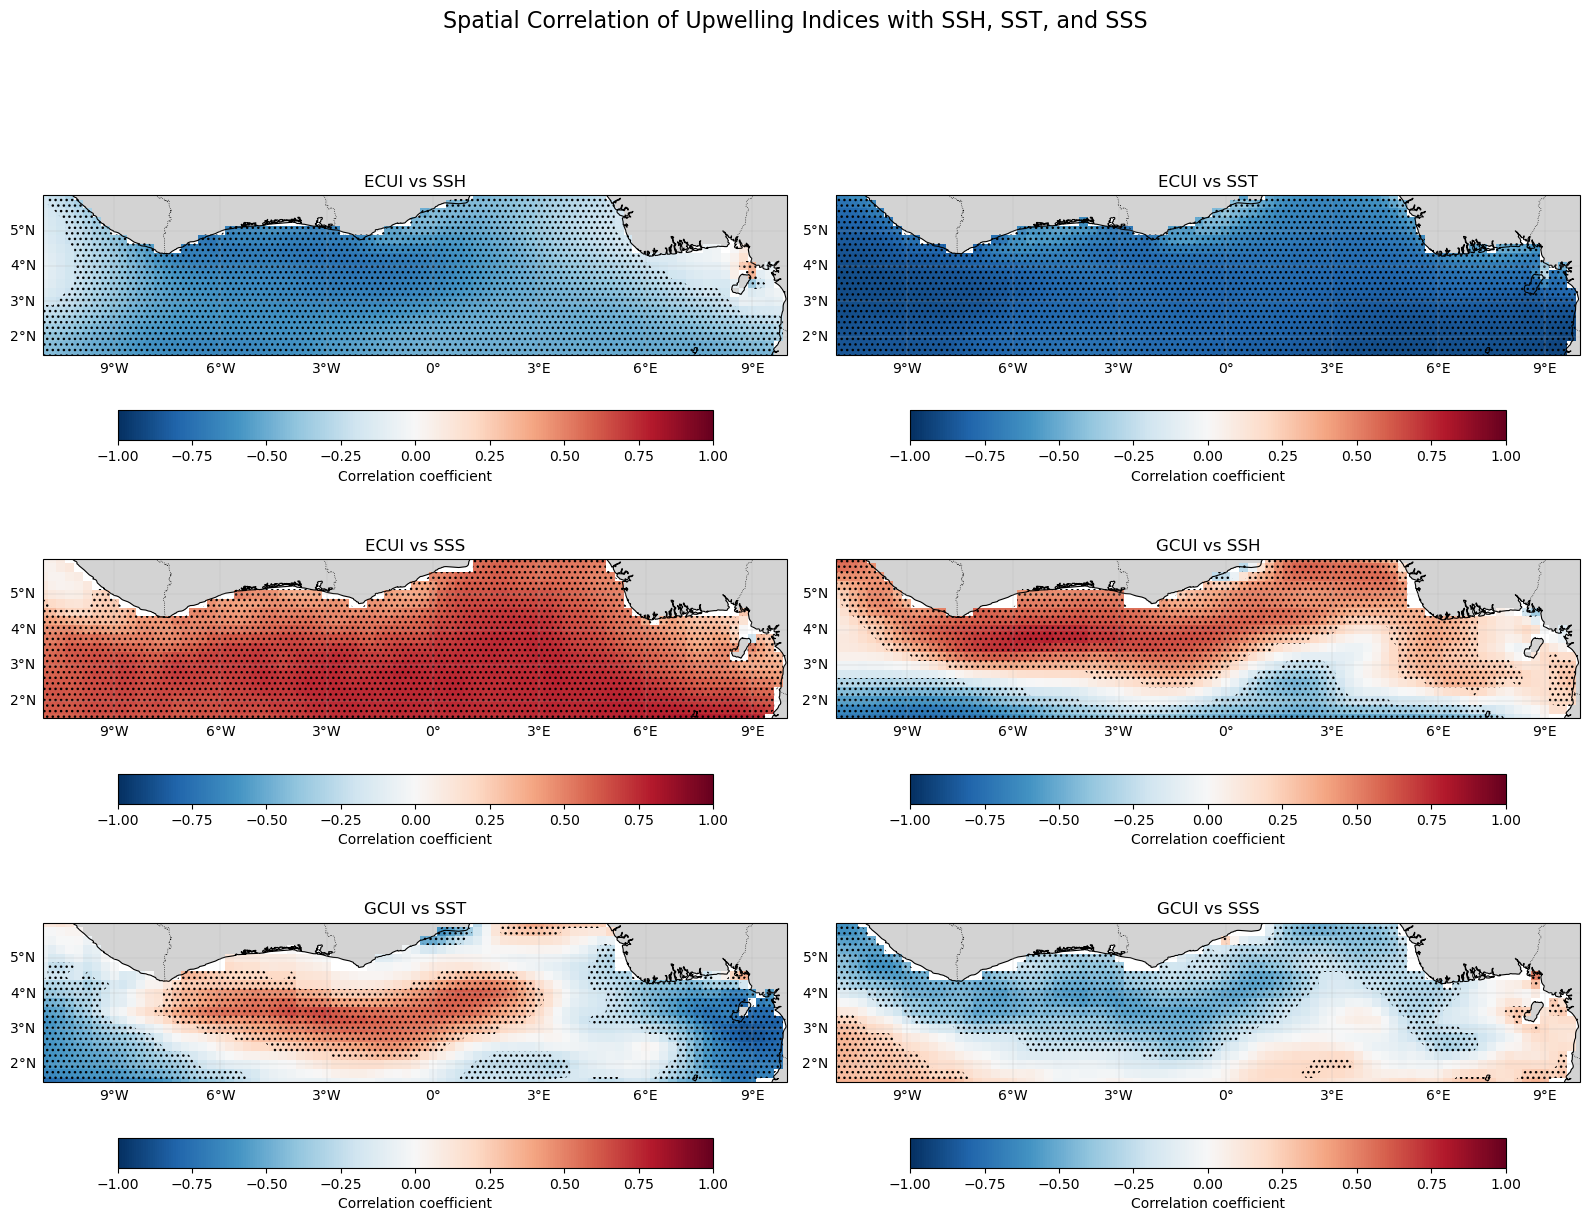

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})

datasets = [
    (correlation_ECUI_SSH, "ECUI vs SSH"),
    (correlation_ECUI_SST, "ECUI vs SST"),
    (correlation_ECUI_SSS, "ECUI vs SSS"),
    (correlation_GCUI_SSH, "GCUI vs SSH"),
    (correlation_GCUI_SST, "GCUI vs SST"),
    (correlation_GCUI_SSS, "GCUI vs SSS"),
]

sig_masks = [
    sig_ECUI_SSH,
    sig_ECUI_SST,
    sig_ECUI_SSS,
    sig_GCUI_SSH,
    sig_GCUI_SST,
    sig_GCUI_SSS,
]

for ax, (data, title), sig_mask in zip(axes.flat, datasets, sig_masks):
    # Plot correlation
    im = ax.pcolormesh(
        data.longitude, data.latitude, data,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r', vmin=-1, vmax=1,
        shading='auto'
    )

    # Add significance as hatching overlay
    ax.contourf(
        data.longitude, data.latitude, sig_mask,
        levels=[0.5, 1], hatches=['...', None], colors='none',
        transform=ccrs.PlateCarree()
    )

    # Map features
    ax.coastlines(resolution='10m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.set_extent([-11, 10, 1.5, 6], crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=12)
    ax.gridlines(draw_labels={'bottom': 'x', 'left': 'y'}, linewidth=0.2)

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.8)
    cbar.set_label('Correlation coefficient')



plt.tight_layout()
plt.suptitle("Spatial Correlation of Upwelling Indices with SSH, SST, and SSS", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.95)
plt.savefig('figures/correlation_1.png')
plt.show()

In [19]:
# ---------- helpers (reuseable) ----------
def ensure_time_dim(da):
    """Ensure a single time-like dim named 'time'."""
    if 'valid_time' in da.coords and 'valid_time' not in da.dims:
        da = da.drop_vars('valid_time')
    if 'time' in da.dims:
        if 'valid_time' in da.coords:
            da = da.drop_vars('valid_time')
        return da
    if 'valid_time' in da.dims:
        if 'time' in da.coords and 'time' not in da.dims:
            da = da.drop_vars('time')
        return da.rename({'valid_time': 'time'})
    raise ValueError("No time-like dimension found (need 'time' or 'valid_time').")

def finite_only(da):
    return da.where(np.isfinite(da))

def corr_1d_masked(x, y, min_n=8):
    """Pearson r,p for 1-D arrays with NaN handling."""
    m = np.isfinite(x) & np.isfinite(y)
    n = int(m.sum())
    if n < min_n:
        return np.nan, np.nan, n
    r, p = pearsonr(x[m], y[m])
    return r, p, n

def lagged_corr_lon(a, b, lags=np.arange(-6, 7), lat_band=slice(1.5, 6.0), min_n=8):
    """
    Lagged correlation with lag on 'time' and correlation computed at each longitude.
    a, b: DataArray(time, latitude, longitude) (depth will be averaged if present).
    Returns Dataset with dims (lag, longitude) containing r, p, n.
    """
    # normalize dims
    a = ensure_time_dim(a); b = ensure_time_dim(b)
    if 'depth' in a.dims: a = a.mean('depth')
    if 'depth' in b.dims: b = b.mean('depth')

    # average over latitude band (coastal strip)
    a = a.sel(latitude=lat_band).mean('latitude')
    b = b.sel(latitude=lat_band).mean('latitude')

    # align times
    a, b = xr.align(a, b, join='inner')
    a = finite_only(a); b = finite_only(b)

    # shapes are (time, longitude)
    lons = a['longitude']
    out_r = xr.full_like(lons, np.nan).expand_dims(lag=lags).astype(float)
    out_p = out_r.copy()
    out_n = xr.full_like(out_r, np.nan).astype(int)

    def corr_vs_lon_for_lag(a2d, b2d, L):
        # corr[a(t), b(t+L)]
        if L > 0:
            aL, bL = a2d, b2d.shift(time=-L)
        elif L < 0:
            aL, bL = a2d.shift(time=+L), b2d
        else:
            aL, bL = a2d, b2d
        aL, bL = xr.align(aL, bL, join='inner')
        aL = finite_only(aL); bL = finite_only(bL)
        r, p, n = xr.apply_ufunc(
            lambda x, y: corr_1d_masked(x, y, min_n=min_n),
            aL, bL,
            input_core_dims=[['time'], ['time']],
            output_core_dims=[[], [], []],
            vectorize=True, dask='parallelized',
            output_dtypes=[float, float, int]
        )
        return r, p, n

    # compute for each lag
    Rs, Ps, Ns = [], [], []
    for L in lags:
        rL, pL, nL = corr_vs_lon_for_lag(a, b, int(L))
        Rs.append(rL); Ps.append(pL); Ns.append(nL)

    out_r.loc[:, :] = xr.concat(Rs, dim='lag').values
    out_p.loc[:, :] = xr.concat(Ps, dim='lag').values
    out_n.loc[:, :] = xr.concat(Ns, dim='lag').values
    return xr.Dataset({'r': out_r, 'p': out_p, 'n': out_n})

C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dty

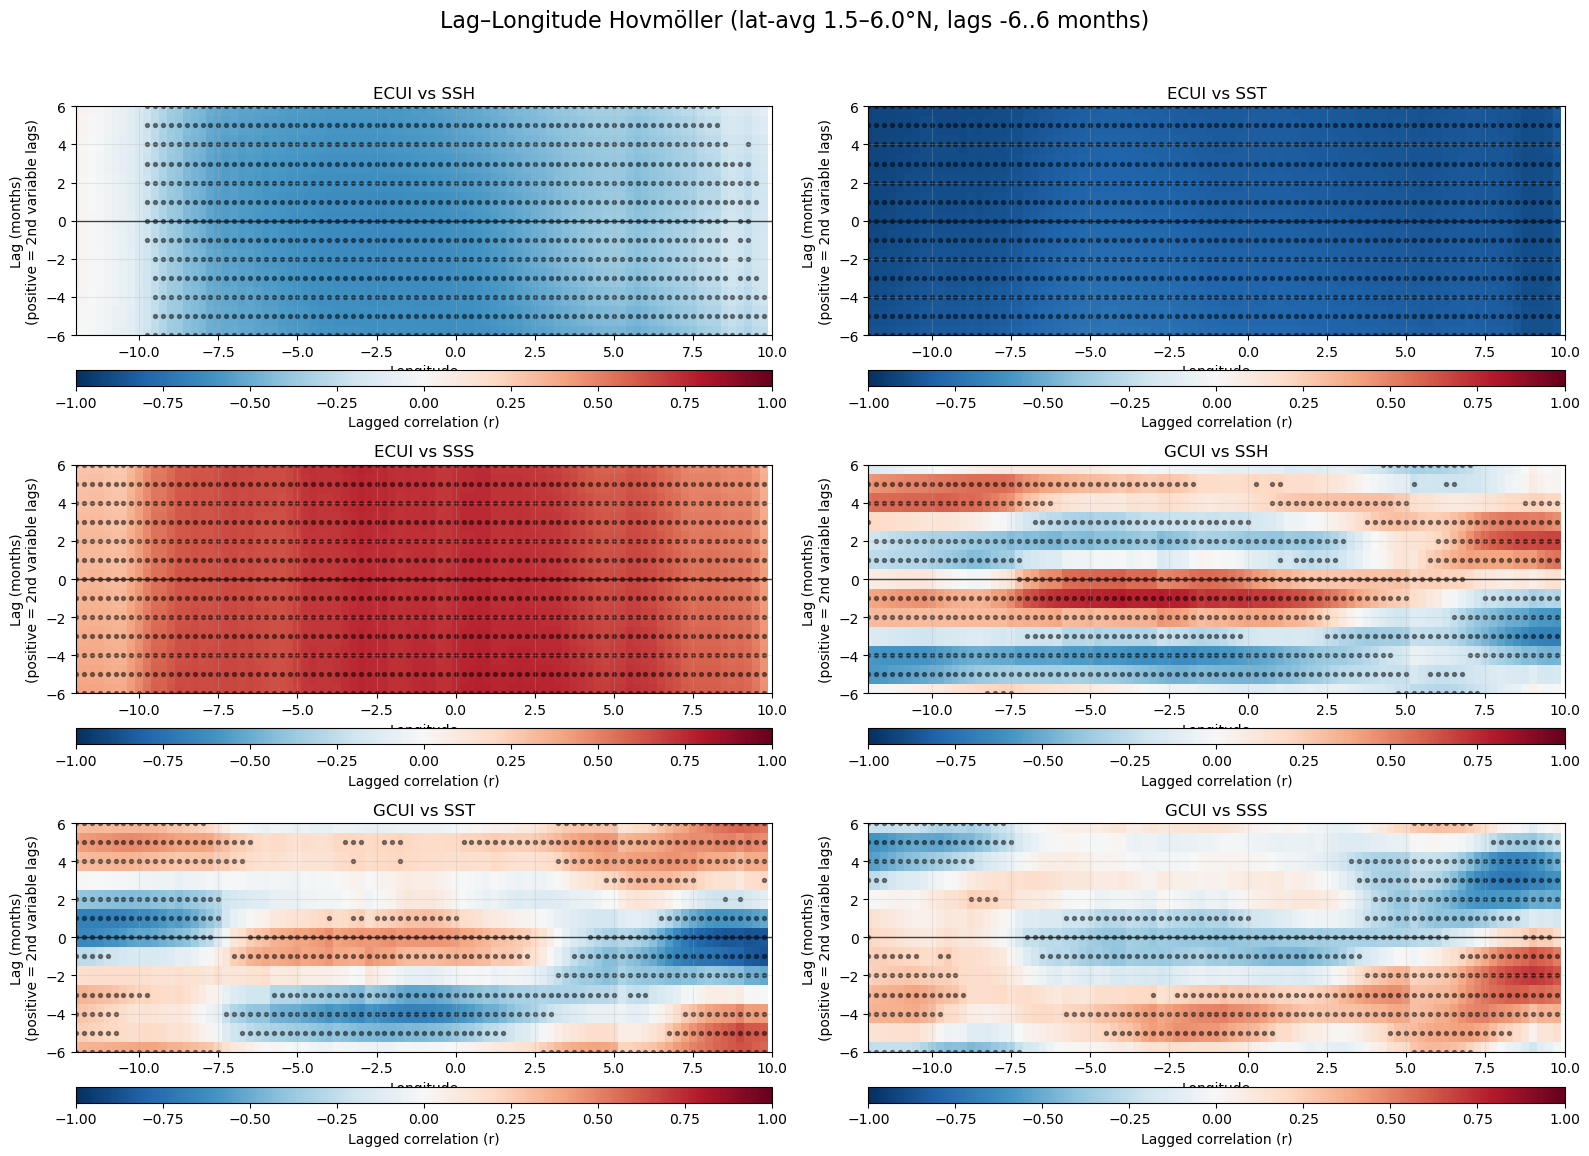

In [20]:
# ---------- choose settings ----------
lat_band = slice(1.5, 6.0)   # coastal band to average over
lags = np.arange(-6, 7)      # -6..+6 months
vlim = 1.0                   # symmetric color limit for all panels
sig_alpha = 0.45             # stipple transparency

# ---------- compute all six pairs ----------
ECUI = ensure_time_dim(ECUI); GCUI = ensure_time_dim(GCUI)
SSH  = ensure_time_dim(SSH_interp); SST = ensure_time_dim(SST_interp); SSS = ensure_time_dim(SSS_interp)

ds_ECUI_SSH = lagged_corr_lon(ECUI, SSH, lags=lags, lat_band=lat_band)
ds_ECUI_SST = lagged_corr_lon(ECUI, SST, lags=lags, lat_band=lat_band)
ds_ECUI_SSS = lagged_corr_lon(ECUI, SSS, lags=lags, lat_band=lat_band)

ds_GCUI_SSH = lagged_corr_lon(GCUI, SSH, lags=lags, lat_band=lat_band)
ds_GCUI_SST = lagged_corr_lon(GCUI, SST, lags=lags, lat_band=lat_band)
ds_GCUI_SSS = lagged_corr_lon(GCUI, SSS, lags=lags, lat_band=lat_band)

pairs = [
    (ds_ECUI_SSH, "ECUI vs SSH"),
    (ds_ECUI_SST, "ECUI vs SST"),
    (ds_ECUI_SSS, "ECUI vs SSS"),
    (ds_GCUI_SSH, "GCUI vs SSH"),
    (ds_GCUI_SST, "GCUI vs SST"),
    (ds_GCUI_SSS, "GCUI vs SSS"),
]

# ---------- plot 3×2 panel (horizontal colorbar under each) ----------
fig, axes = plt.subplots(3, 2, figsize=(16, 12), squeeze=False)

for ax, (dsL, title) in zip(axes.flat, pairs):
    r = dsL['r']; p = dsL['p']
    lons = r['longitude']; lag_vals = r['lag']

    # field
    im = ax.pcolormesh(lons, lag_vals, r, cmap='RdBu_r',
                       vmin=-vlim, vmax=vlim, shading='auto')

    # zero-lag line
    ax.axhline(0, color='k', linewidth=1, alpha=0.7)

    # significance dots
    sig = (p < 0.05) & np.isfinite(r)
    XX, YY = np.meshgrid(lons, lag_vals)
    ax.scatter(XX[sig.values], YY[sig.values], s=8, c='k', alpha=sig_alpha)

    ax.set_xlim(float(lons.min()), float(lons.max()))
    ax.set_ylim(lag_vals.min(), lag_vals.max())
    ax.grid(True, alpha=0.25)
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Lag (months)\n(positive = 2nd variable lags)")

    # colorbar under each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7%", pad=0.35)
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label("Lagged correlation (r)")

plt.suptitle(f"Lag–Longitude Hovmöller (lat-avg {lat_band.start}–{lat_band.stop}°N, lags {lags.min()}..{lags.max()} months)",
             fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.savefig("figures/lag_hovmoller_3x2.png", dpi=150)
plt.show()


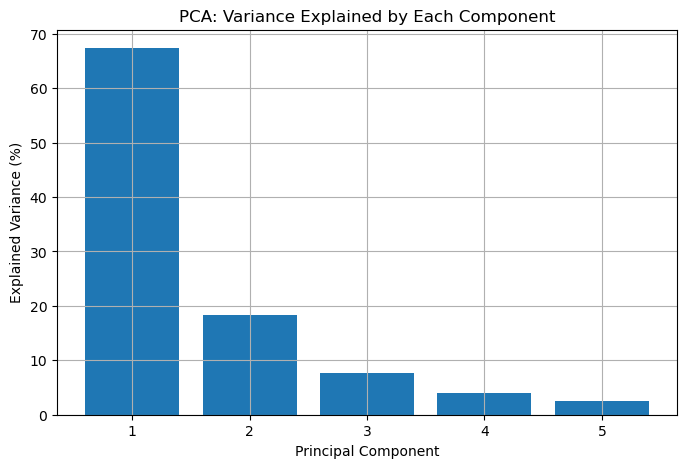

Principal Component Loadings:


,GCUI,ECUI,SST,SSH,SSS
PC1,0.312590,0.493484,-0.479135,-0.446255,0.479632
PC2,-0.805494,0.310854,-0.211238,0.338363,0.308930
PC3,0.388218,-0.055481,-0.571920,0.712965,-0.103906
PC4,0.203811,-0.324259,0.357826,0.268607,0.808164
PC5,0.247416,0.742712,0.520265,0.325418,-0.102911


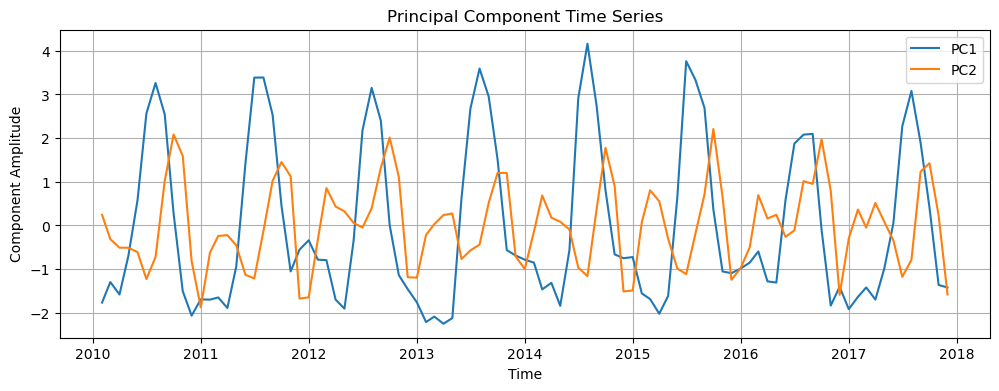

In [22]:
### PCA Analysis: Synergistic Influence of GCUI, ECUI, SST, SSH, and SSS

# Step 1: Subset to the Keta region
# Adjust the lat/lon bounds to focus on Keta (example: ~0.5°N to 6.0°N, 0°E to 2°E)
lat_range = slice(0.5, 6.0)
lon_range = slice(0.0, 2.0)

# gcui_keta = GCUI.sel(latitude=lat_range, longitude=lon_range).mean(dim=["latitude", "longitude"], skipna=True)
# ecui_keta = ECUI.sel(latitude=lat_range, longitude=lon_range).mean(dim=["latitude", "longitude"], skipna=True)
# sst_keta = SST.sel(latitude=lat_range, longitude=lon_range).mean(dim=["latitude", "longitude"], skipna=True)
# ssh_keta = SSH.sel(latitude=lat_range, longitude=lon_range).mean(dim=["latitude", "longitude"], skipna=True)
# sss_keta = SSS.sel(latitude=lat_range, longitude=lon_range).mean(dim=["latitude", "longitude"], skipna=True)


gcui_keta = GCUI.mean(dim=["latitude", "longitude"], skipna=True)
ecui_keta = ECUI.mean(dim=["latitude", "longitude"], skipna=True)
sst_keta = SST.mean(dim=["latitude", "longitude"], skipna=True)
ssh_keta = SSH.mean(dim=["latitude", "longitude"], skipna=True)
sss_keta = SSS.mean(dim=["latitude", "longitude"], skipna=True)

# Step 2: Convert to pandas Series and align time
gcui_series = gcui_keta.to_series().dropna()
ecui_series = ecui_keta.to_series().dropna()
sst_series = sst_keta.to_series().dropna()
ssh_series = ssh_keta.to_series().dropna()
sss_series = sss_keta.to_series().dropna()

# Inner join on common dates
df = (
    pd.concat([gcui_series, ecui_series, sst_series, ssh_series, sss_series], axis=1)
    .dropna()
)
df.columns = ["GCUI", "ECUI", "SST", "SSH", "SSS"]

# Step 3: Standardize and apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = df.values
X_std = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

# Step 4: Visualize explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_ * 100)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("PCA: Variance Explained by Each Component")
plt.grid()
plt.show()

# Step 5: Display loadings
import pandas as pd
loadings = pd.DataFrame(pca.components_, columns=df.columns, index=[f"PC{i+1}" for i in range(len(df.columns))])
print("Principal Component Loadings:")
display(loadings)

# Optional: Show principal component time series
plt.figure(figsize=(12, 4))
plt.plot(df.index, X_pca[:, 0], label="PC1")
plt.plot(df.index, X_pca[:, 1], label="PC2")
plt.title("Principal Component Time Series")
plt.xlabel("Time")
plt.ylabel("Component Amplitude")
plt.legend()
plt.grid()
plt.show()


In [57]:
# for ax, (data, title) in zip(axes.flat, datasets):
#     # Plot the correlation map with smoother shading
#     im = ax.pcolormesh(
#         data.longitude, data.latitude, data,
#         transform=ccrs.PlateCarree(),
#         cmap='RdBu_r', vmin=-1, vmax=1,
#         shading='auto'
#     )
    
#     # Add map features
#     ax.coastlines(resolution='10m', linewidth=0.8)
#     ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
#     ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
#     ax.set_extent([-11, 10, 1.5, 6], crs=ccrs.PlateCarree())

#     ax.set_title(title, fontsize=12)
#     #ax.set_xticks(range(-10, 11, 5), crs=ccrs.PlateCarree())
#     #ax.set_yticks(range(-2, 7, 2), crs=ccrs.PlateCarree())
#     ax.gridlines(draw_labels=True, linewidth=0.2)

#     # Add colorbar
#     cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.4)
#     cbar.set_label('Correlation coefficient')


In [78]:

def finite_only(da):
    return da.where(np.isfinite(da))

def corr_1d_masked(x, y, min_n=8):
    """Pearson r,p for 1-D arrays with NaN handling."""
    m = np.isfinite(x) & np.isfinite(y)
    n = int(m.sum())
    if n < min_n:
        return np.nan, np.nan, n
    r, p = pearsonr(x[m], y[m])
    return r, p, n

In [83]:
def lagged_corr_lon(a, b, lags=np.arange(-6, 7), lat_band=slice(1.5, 6), min_n=8):
    """
    Lagged correlation with lag on 'time' and correlation computed at each longitude.
    a, b: DataArray(time, latitude, longitude) (depth will be averaged if present).
    Returns Dataset with dims (lag, longitude) containing r, p, n.
    """
    # normalize dims
    a = ensure_time_dim(a); b = ensure_time_dim(b)
    if 'depth' in a.dims: a = a.mean('depth')
    if 'depth' in b.dims: b = b.mean('depth')

    # average a & b over latitude band (coastal strip)
    a = a.sel(latitude=lat_band).mean('latitude')
    b = b.sel(latitude=lat_band).mean('latitude')

    # align times (inner join)
    a, b = xr.align(a, b, join='inner')
    a = finite_only(a); b = finite_only(b)

    # after the lat-mean, both shapes are (time, longitude)
    lons = a['longitude']
    out_r = xr.full_like(lons, np.nan).expand_dims(lag=lags).astype(float)
    out_p = out_r.copy()
    out_n = xr.full_like(out_r, np.nan).astype(int)

    # vectorized across longitude using apply_ufunc
    def corr_vs_lon_for_lag(a2d, b2d, L):
        # a2d,b2d: (time, lon). Apply lag: corr[a(t), b(t+L)]
        if L > 0:
            # b leads → shift b backward
            bL = b2d.shift(time=-L)
            aL = a2d
        elif L < 0:
            # a leads → shift a backward
            aL = a2d.shift(time=+L)  # L is negative
            bL = b2d
        else:
            aL, bL = a2d, b2d

        # align after shift (drop NaNs at ends)
        aL, bL = xr.align(aL, bL, join='inner')
        aL = finite_only(aL); bL = finite_only(bL)

        # apply pearsonr along time for each lon
        r, p, n = xr.apply_ufunc(
            lambda x, y: corr_1d_masked(x, y, min_n=min_n),
            aL, bL,
            input_core_dims=[['time'], ['time']],
            output_core_dims=[[], [], []],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[float, float, int]
        )
        return r, p, n

    # fill outputs for each lag
    results = []
    for L in lags:
        rL, pL, nL = corr_vs_lon_for_lag(a, b, int(L))
        results.append((rL, pL, nL))

    out_r.loc[:, :] = xr.concat([rp[0] for rp in results], dim='lag').values
    out_p.loc[:, :] = xr.concat([rp[1] for rp in results], dim='lag').values
    out_n.loc[:, :] = xr.concat([rp[2] for rp in results], dim='lag').values

    return xr.Dataset({'r': out_r, 'p': out_p, 'n': out_n})



In [93]:
def plot_hov_lag_lon(ds_lag, filename, title="", vlim=1.0, signif=0.05):
    """
    Plot Hovmöller with lag on y and longitude on x.
    ds_lag: Dataset returned by lagged_corr_lon (dims: lag, longitude).
    """
    r = ds_lag['r']; p = ds_lag['p']
    lons = r['longitude']; lags = r['lag']

    fig, ax = plt.subplots(figsize=(12, 6))
    vv = float(vlim)
    pcm = ax.pcolormesh(lons, lags, r, cmap='RdBu_r', vmin=-vv, vmax=vv, shading='auto')
    cb = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.12)
    cb.set_label("Lagged correlation (r)")

    # zero-lag reference line
    ax.axhline(0, color='k', linewidth=1, alpha=0.7)

    # significance stippling
    sig = (p < signif) & np.isfinite(r)
    XX, YY = np.meshgrid(lons, lags)
    ax.scatter(XX[sig.values], YY[sig.values], s=8, c='k', alpha=0.45)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Lag (months)\n(positive = field on x-axis lags)")
    ax.set_title(title)
    ax.set_xlim(float(lons.min()), float(lons.max()))
    ax.set_ylim(lags.min(), lags.max())
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.savefig(f"figures/{filename}.png")
    #plt.show()



C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


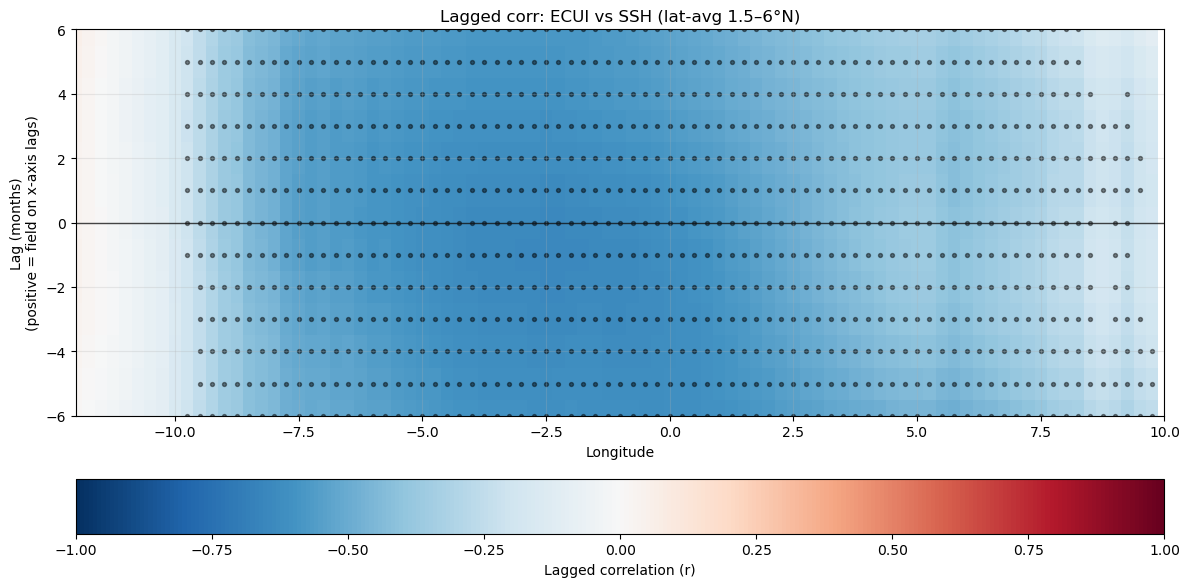

In [94]:
# ---------- EXAMPLES ----------
# Choose coastal latitude band and lags (months)
lat_band = slice(1.5, 6.0)
lags = np.arange(-6, 7)  # -6..+6 months

# 1) ECUI leads/follows SSH along the coast
ds_lag_ECUI_SSH = lagged_corr_lon(ECUI, SSH_interp, lags=lags, lat_band=lat_band)
plot_hov_lag_lon(ds_lag_ECUI_SSH, filename='Lagged_corr_ECUI_vs_SSH', title="Lagged corr: ECUI vs SSH (lat-avg 1.5–6°N)", vlim=1.0)



C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


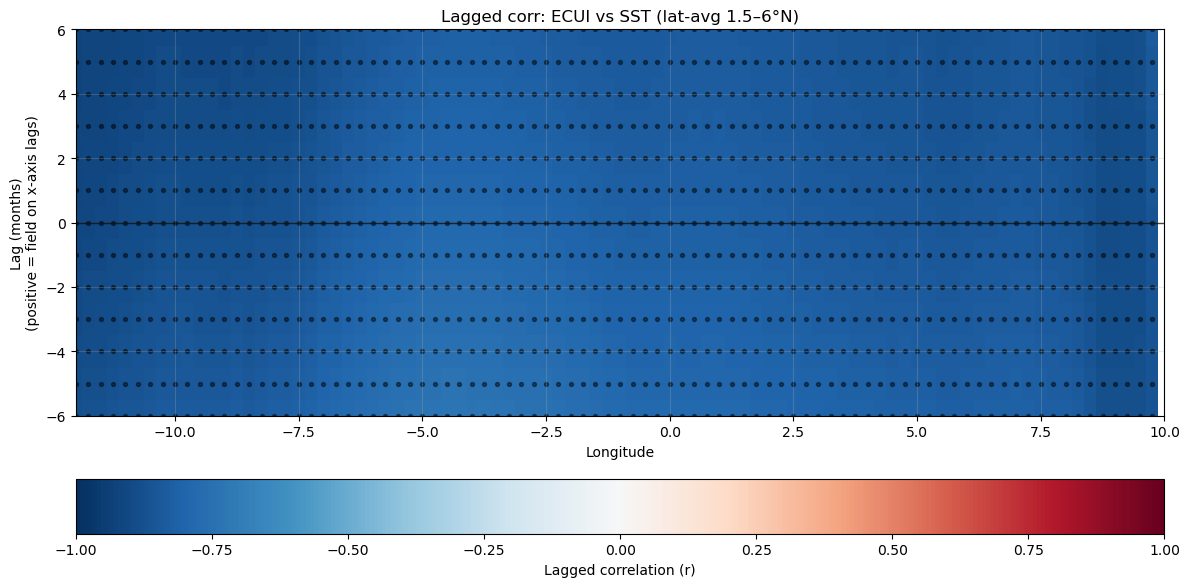

In [95]:
# 2) ECUI vs SST
ds_lag_ECUI_SST = lagged_corr_lon(ECUI, SST_interp, lags=lags, lat_band=lat_band)
plot_hov_lag_lon(ds_lag_ECUI_SST,filename='Lagged_corr_ECUI_vs SST', title="Lagged corr: ECUI vs SST (lat-avg 1.5–6°N)", vlim=1.0)



C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


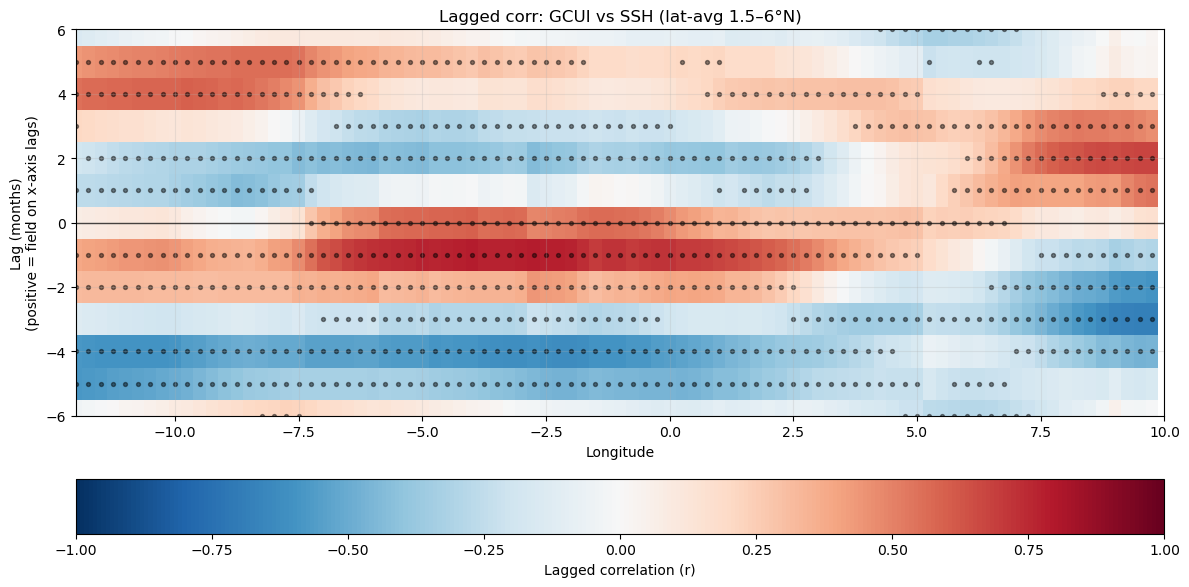

In [96]:
# 3) GCUI vs SSH (to see current–sea level timing)
ds_lag_GCUI_SSH = lagged_corr_lon(GCUI, SSH_interp, lags=lags, lat_band=lat_band)
plot_hov_lag_lon(ds_lag_GCUI_SSH, filename='Lagged_corr_GCUI_vs_SSH', title="Lagged corr: GCUI vs SSH (lat-avg 1.5–6°N)", vlim=1.0)

C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\Annorion\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dty

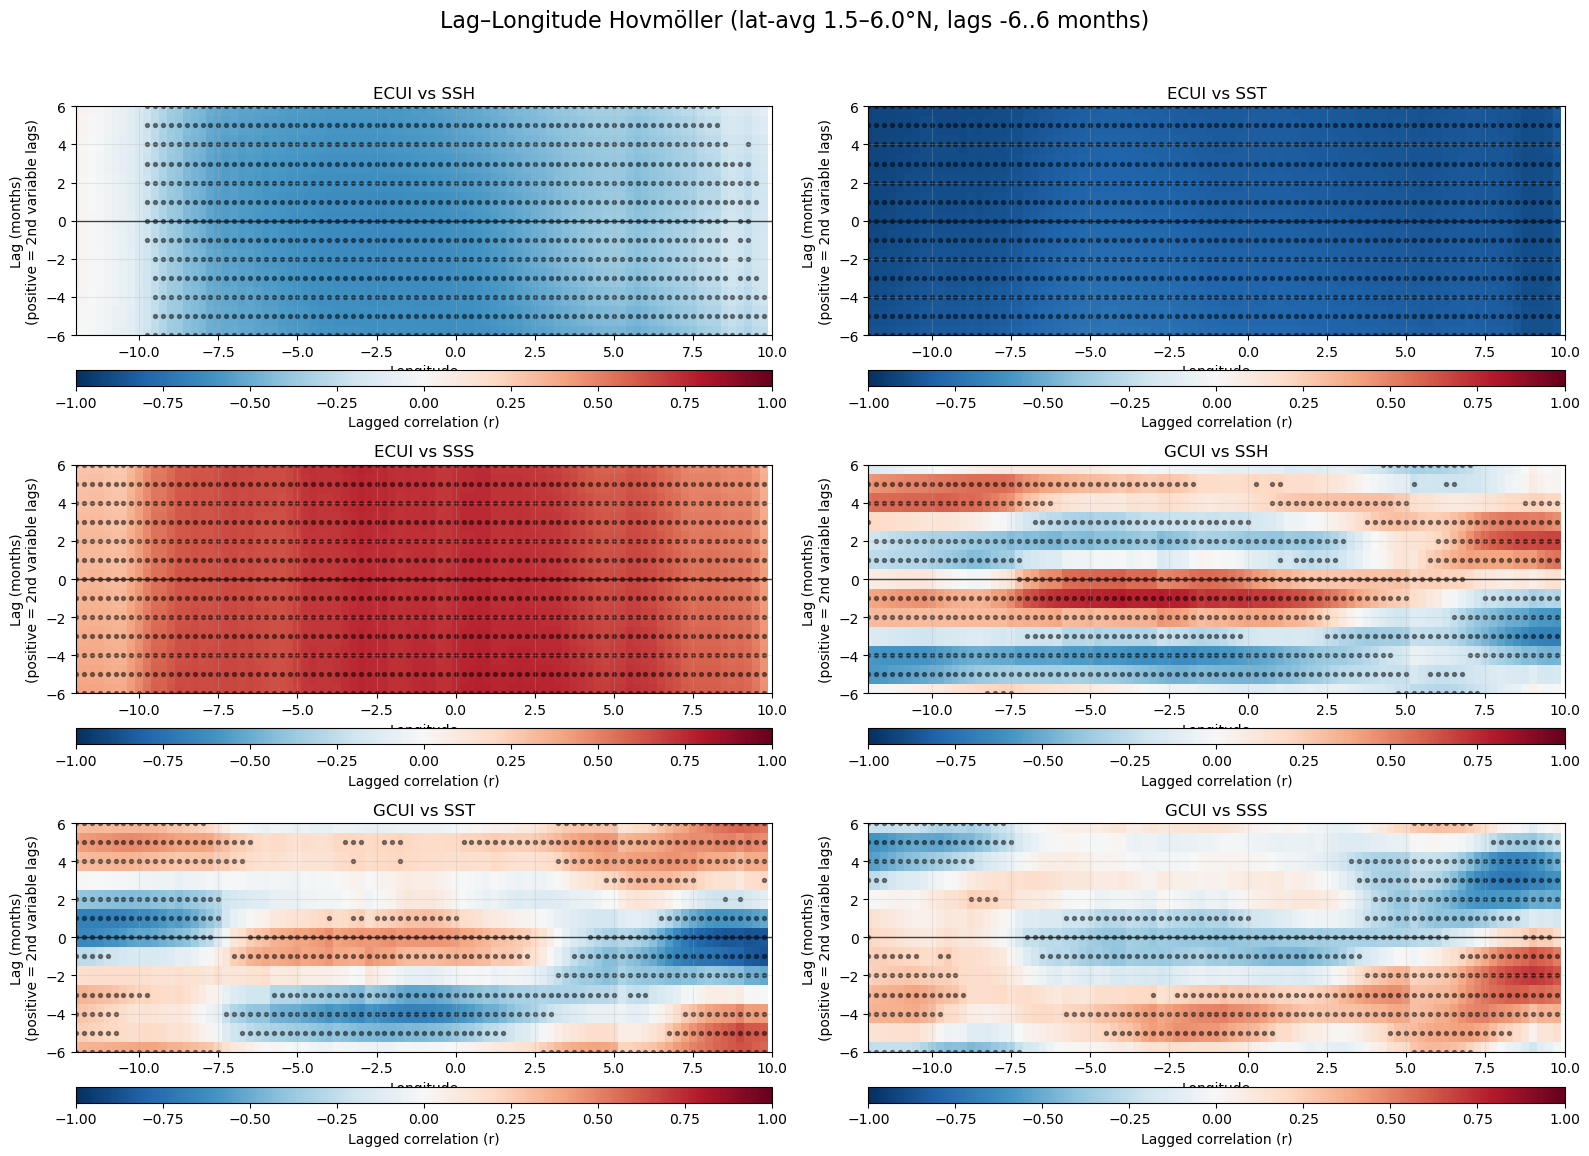

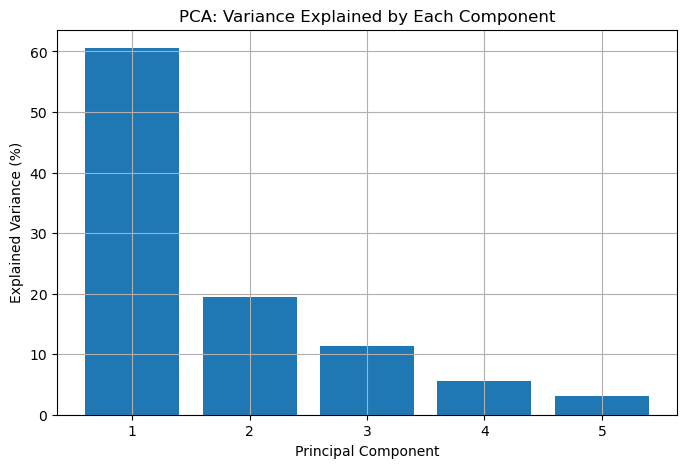

Principal Component Loadings:


,GCUI,ECUI,SST,SSH,SSS
PC1,-0.151467,0.513256,-0.519877,-0.424364,0.513097
PC2,0.975824,0.132401,-0.002593,-0.173617,0.009402
PC3,0.094254,0.401561,-0.352348,0.839265,-0.036740
PC4,-0.074353,0.222749,-0.364941,-0.288799,-0.853386
PC5,0.102047,-0.712860,-0.687306,0.044738,0.083819


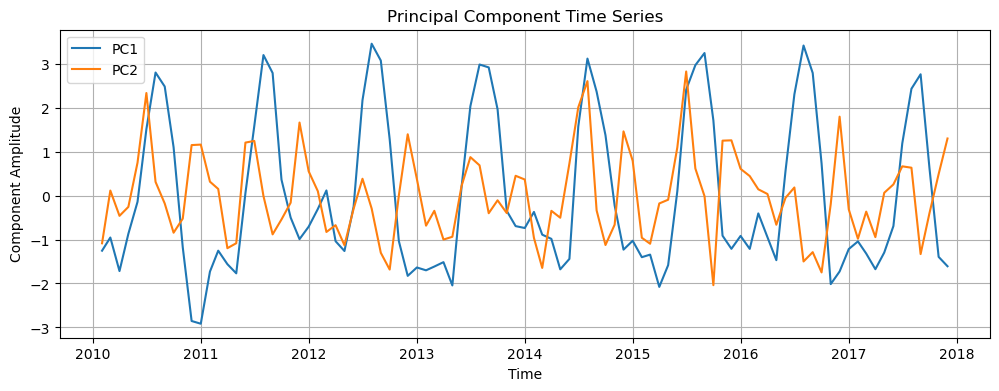